In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive
%cd MyDrive/
%cd ITCS_5156_Project

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ITCS_5156_Project


# Imports

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
import string
import copy
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
import tensorflow as tf
from tensorflow import keras

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Borrowed this testing code from a Google Colab demo to ensure GPU is mounted
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Data Loading/Preprocessing

In [ ]:
#data load
text = pd.read_csv('dictionary.txt', sep='|', names=('sentence', 'phrase ids'))
sentiment = pd.read_csv('sentiment_labels.txt', sep='|')
print(text.head())
print(sentiment.head())

      sentence  phrase ids
0            !           0
1          ! '       22935
2         ! ''       18235
3       ! Alas      179257
4  ! Brilliant       22936
   phrase ids  sentiment values
0           0           0.50000
1           1           0.50000
2           2           0.44444
3           3           0.50000
4           4           0.42708


In [ ]:
#join the sentiment to the corresponding phrase id
df = text.merge(right=sentiment, how='inner', on='phrase ids')
df.head()

,sentence,phrase ids,sentiment values
0,!,0,0.50000
1,! ',22935,0.52778
2,! '',18235,0.50000
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111


In [ ]:
#remove punctuation from sentences
df['preprocessed sentence'] = df['sentence'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
df.head()

,sentence,phrase ids,sentiment values,preprocessed sentence
0,!,0,0.50000,
1,! ',22935,0.52778,
2,! '',18235,0.50000,
3,! Alas,179257,0.44444,Alas
4,! Brilliant,22936,0.86111,Brilliant


In [ ]:
#drop blank sentences (or sentences that were previously entirely punctuation)
index_blanks = df[ (df['preprocessed sentence'] == '') | (df['preprocessed sentence'] == ' ')].index
df = df.drop(index_blanks)
df.head()

,sentence,phrase ids,sentiment values,preprocessed sentence
3,! Alas,179257,0.44444,Alas
4,! Brilliant,22936,0.86111,Brilliant
5,! Brilliant !,40532,0.93056,Brilliant
6,! Brilliant ! ',22937,1.00000,Brilliant
7,! C'mon,60624,0.47222,Cmon


In [ ]:
#convert to lower case
df['preprocessed sentence'] = df['preprocessed sentence'].str.lower()

In [ ]:
#tokenize the sentences
df['preprocessed tf idf training'] = df['preprocessed sentence']
df['preprocessed sentence'] = df['preprocessed sentence'].apply(nltk.word_tokenize)
df.head()

,sentence,phrase ids,sentiment values,preprocessed sentence,preprocessed tf idf training
3,! Alas,179257,0.44444,[alas],alas
4,! Brilliant,22936,0.86111,[brilliant],brilliant
5,! Brilliant !,40532,0.93056,[brilliant],brilliant
6,! Brilliant ! ',22937,1.00000,[brilliant],brilliant
7,! C'mon,60624,0.47222,[cmon],cmon


In [ ]:
#Drop unnecessary columns
df = df.drop(['sentence', 'phrase ids'], axis=1)
df.head()

,sentiment values,preprocessed sentence,preprocessed tf idf training
3,0.44444,[alas],alas
4,0.86111,[brilliant],brilliant
5,0.93056,[brilliant],brilliant
6,1.00000,[brilliant],brilliant
7,0.47222,[cmon],cmon


In [ ]:
#Based on documentation from the original dataset, divide into 5 data classes
def sentiment_to_class(sentiment):
  if sentiment <= 0.2:
    return 1
  elif sentiment <= 0.4:
    return 2
  elif sentiment <= 0.6:
    return 3
  elif sentiment <= 0.8:
    return 4
  elif sentiment <= 1.0:
    return 5

df['sentiment class'] = df['sentiment values'].apply(sentiment_to_class)
df.head()

,sentiment values,preprocessed sentence,preprocessed tf idf training,sentiment class
3,0.44444,[alas],alas,3
4,0.86111,[brilliant],brilliant,5
5,0.93056,[brilliant],brilliant,5
6,1.00000,[brilliant],brilliant,5
7,0.47222,[cmon],cmon,3


# Topic Words Selection

In [ ]:
#Based on equation 1 of "A Topic Matching based CNN for Sentence Classification"
#Select K most important words with respect to each class

def k_important_words(data, k, num_classes=5, smoothing_constant=1):
  #stores return value, a (num_classes * k) list of words
  words = []
  #stores word counts by class
  word_dict = {}
  #create a default list of 0s based on number of classes
  default_list = []
  for each in range(num_classes):
    default_list.append(0)
  
  #get number of occurrences of each word by class
  for class_num in range(num_classes):
    for sentence, class_val in zip(df['preprocessed sentence'], df['sentiment class']):
      #this condition prevents iterating over the same sentence multiple times
      if class_val == class_num+1:
        #go through each word in the sentence
        for word in sentence:
          #if word has been seen before
          if word in word_dict:
            #add 1 to instances associated with each class
            word_dict[word][class_num] += 1
          #if word has not been seen before
          else:
            #assign a list of 0s for each class, then add 1 to the current class
            word_dict[word] = copy.copy(default_list)
            word_dict[word][class_num] += 1


  #get total count of word instances associated with each class
  words_per_class = copy.copy(default_list)    
  for key in word_dict:
    for class_num in range(num_classes):
      #add the count of the word associated with that class to the total class word count
      words_per_class[class_num] += word_dict[key][class_num]

  #get total number of word instances
  total_word_instances = 0
  for each in words_per_class:
    total_word_instances += each

  #create a dictionary to store the Naive Bayes weights
  word_nb_vals = {}
  #calculate NB weights by class:
  for word in word_dict:
    weights = copy.copy(default_list)
    for class_num in range(num_classes):
      #numerator = number of word w in class c + smoothing / count of all words in class c
      
      nb_numerator = (word_dict[word][class_num] + smoothing_constant)/(words_per_class[class_num]+smoothing_constant)
      #denominator = number of word w in other classes (all instances of word w - instances of w in class c) + smoothing / count of all words in other classes (total words - # words in class c)
      nb_denominator = (sum(word_dict[word]) - word_dict[word][class_num] + smoothing_constant)/(total_word_instances - words_per_class[class_num]+smoothing_constant)
      weights[class_num] = nb_numerator/nb_denominator
    #add weights to dictionary with key of the word
    word_nb_vals[word] = weights
  
  #find top k words for each class

  #decompose dictionary into separate dictionaries for each class:
  dict_list = []
  for class_num in range(num_classes):
    class_dict = {}
    for word in word_nb_vals:
      class_dict[word] = word_nb_vals[word][class_num]
    dict_list.append(class_dict)

  for class_num in range(num_classes):
    for word in sorted(dict_list[class_num], key=dict_list[class_num].get, reverse=True)[:k]:
      words.append(word)
  
  return words

important_words = k_important_words(df, 5)

In [ ]:
w2v = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#include this example here as a demonstration, but also because the first word passed through the w2v model is very slow
type(w2v['when'])

numpy.ndarray

In [ ]:
#eliminate words not found in the w2v model
true_important_words = []
for word in important_words:
  try:
    w2v[word]
    true_important_words.append(word)
  except:
    print(word + " is not found in w2v")

baaaaaaaaad is not found in w2v
illstarred is not found in w2v
papai is not found in w2v
hardwon is not found in w2v
nearmasterpiece is not found in w2v
allages is not found in w2v


In [ ]:
#Get vector representations of each of the important words
important_word_vectors = []

for word_index in range(len(true_important_words)):
  important_word_vectors.append(w2v[true_important_words[word_index]])

important_word_vectors = np.array(important_word_vectors) 
print(important_word_vectors)
print(important_word_vectors.shape)

[[ 0.18164062  0.09033203  0.26757812 ... -0.33398438  0.14453125
   0.01867676]
 [-0.109375   -0.2578125   0.546875   ... -0.34179688  0.00686646
   0.13769531]
 [ 0.1796875  -0.01879883  0.04467773 ... -0.125       0.03833008
   0.30078125]
 ...
 [ 0.04272461  0.16894531  0.14941406 ... -0.06591797  0.1328125
   0.09033203]
 [ 0.04785156 -0.07910156  0.02600098 ... -0.1328125   0.12890625
  -0.02148438]
 [-0.125       0.09033203 -0.15527344 ... -0.13183594  0.30273438
   0.17578125]]
(19, 300)


In [ ]:
#Get word similarities for each word in the sentence and make a matrix:

def word_similarity_matrix(important_word_vector_list, tokenized_sentence):
  word_matrix = []
  valid_sentence = []
  #validate word exists in w2v
  for word in tokenized_sentence:
    try:
      #throws exception if word not found in w2v
      w2v[word]
      valid_sentence.append(word)
    except:
      #print(type(word))
      #print(word)
      #print(word + " is not found in w2v")
      pass
  #return nan if there are no valid words in the review - these will be filtered out pre-model training
  if len(valid_sentence) == 0:
    return np.nan
  for word in valid_sentence:
    similarity_list = []
    vectorized_word = w2v[word]
    for important_vector in important_word_vector_list:
      #similarity is represented as dot product of the two vectorized word representations
      try:
        similarity_list.append(np.dot(vectorized_word.T, important_vector))
      except:
        return np.nan
    similarity_list = np.array(similarity_list)
    word_matrix.append(similarity_list)
  word_matrix = np.array(word_matrix)
  #print(word_matrix.shape)
  return word_matrix

#test:
test_matrix = word_similarity_matrix(important_word_vectors, ["Hello", "world"])
print(test_matrix)
print(test_matrix.shape)

test_matrix = word_similarity_matrix(important_word_vectors, ["Baaaaaaaaaaad"])
print(test_matrix)

[[ 1.1970627   2.0804837   1.554081    0.9806131   0.96571356  1.1314356
   1.7519835   0.39204523  0.72417176  1.6104162   0.7905725   1.9051452
   1.4731799  -0.15510704  0.79635215  0.6702292   0.41663605  0.42023304
   1.180949  ]
 [ 0.19105324  1.6357974   0.14350551  1.0198777   0.16904008  0.3123754
   0.26343107  0.2652284   0.31813186  0.2846771   1.2097617  -0.4225616
   0.48806265  0.9342801   0.5298463  -0.2612962  -0.04626492  0.57601047
   0.28380105]]
(2, 19)
nan


In [ ]:
#Create list of vectors
matrix_list = []
for each in df['preprocessed sentence']:
  matrix_list.append(word_similarity_matrix(important_word_vectors, each))
print(len(matrix_list))

239191


In [ ]:
#some validation steps
print(matrix_list[60])
print(len(matrix_list[60]))
print(df['preprocessed sentence'][60])

count = 0
for each in matrix_list:
  if type(each) == type(np.nan):
    count += 1
print(count)

[[ 4.55972701e-01  4.35321301e-01  3.17010641e-01  1.26763731e-01
   1.67521939e-01  3.85974497e-01  2.81991273e-01  2.78834626e-03
  -1.01123236e-01  4.18850899e-01  3.74981612e-01  1.70319706e-01
   4.14803326e-01  4.30068552e-01  2.42081195e-01  1.43416896e-02
  -5.90860881e-02  9.91777629e-02 -1.17792524e-02]
 [-3.35106432e-01 -7.27089703e-01  1.17678955e-01  6.71997607e-01
  -3.45913060e-02  1.77890763e-01 -1.31178588e-01  1.22236490e-01
   8.51278305e-01  5.19281387e-01 -3.01850468e-01  4.22102779e-01
   7.94597626e-01 -6.40530735e-02  3.44981599e+00  9.99348402e-01
   4.44010019e-01  2.51288891e-01  2.32164115e-02]
 [ 2.52253056e-01  4.54475880e-01 -3.13930809e-02  6.82412744e-01
  -1.74316596e-02  1.07913351e+00  1.25697553e-01  9.75177765e-01
   4.83705342e-01  8.02057147e-01 -2.86975503e-01  8.02154183e-01
   7.84395397e-01  5.73083162e-01  3.14869314e-01 -6.36846304e-01
  -3.93184841e-01  3.49894375e-01  1.33085382e+00]
 [ 1.01841164e+00  1.36264831e-01  4.30050969e-01  6.04

In [ ]:
df['similarity matrix'] = matrix_list
df.head()

,sentiment values,preprocessed sentence,preprocessed tf idf training,sentiment class,similarity matrix
3,0.44444,[alas],alas,3,"[[1.5540344, 2.3854809, 2.6279855, 2.077384, 1..."
4,0.86111,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
5,0.93056,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
6,1.00000,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
7,0.47222,[cmon],cmon,3,"[[1.2385188, 3.1094713, 2.4154541, 1.1341355, ..."


# Final Preprocessing

In [ ]:
#Drop sentences that did not have any valid words
print(len(df['sentiment values']))
df = df.dropna()
df.reset_index(drop=True)
print(len(df['sentiment values']))
df.head()

239191
234762


,sentiment values,preprocessed sentence,preprocessed tf idf training,sentiment class,similarity matrix
3,0.44444,[alas],alas,3,"[[1.5540344, 2.3854809, 2.6279855, 2.077384, 1..."
4,0.86111,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
5,0.93056,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
6,1.00000,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0..."
7,0.47222,[cmon],cmon,3,"[[1.2385188, 3.1094713, 2.4154541, 1.1341355, ..."


In [ ]:
def one_hot_encoding(int_val):
  return_val = np.zeros(5)
  return_val[int_val-1] = 1
  return return_val

df['encoded target'] = df['sentiment class'].apply(one_hot_encoding)
df.head()

,sentiment values,preprocessed sentence,preprocessed tf idf training,sentiment class,similarity matrix,encoded target
3,0.44444,[alas],alas,3,"[[1.5540344, 2.3854809, 2.6279855, 2.077384, 1...","[0.0, 0.0, 1.0, 0.0, 0.0]"
4,0.86111,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0...","[0.0, 0.0, 0.0, 0.0, 1.0]"
5,0.93056,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0...","[0.0, 0.0, 0.0, 0.0, 1.0]"
6,1.00000,[brilliant],brilliant,5,"[[1.6539329, 2.410287, 2.1586046, 1.7286826, 0...","[0.0, 0.0, 0.0, 0.0, 1.0]"
7,0.47222,[cmon],cmon,3,"[[1.2385188, 3.1094713, 2.4154541, 1.1341355, ...","[0.0, 0.0, 1.0, 0.0, 0.0]"


In [ ]:
df['sentiment class'].value_counts()

3    115865
4     49764
2     42627
5     15196
1     11310
Name: sentiment class, dtype: int64

In [ ]:
#Deal with class imbalance by undersampling
class_1 = df[df['sentiment class'] == 1]
class_2 = df[df['sentiment class'] == 2]
class_3 = df[df['sentiment class'] == 3]
class_4 = df[df['sentiment class'] == 4]
class_5 = df[df['sentiment class'] == 5]

#Least common class is 1, so undersample the rest:
class_2 = class_2.sample(n=len(class_1))
class_3 = class_3.sample(n=len(class_1))
class_4 = class_4.sample(n=len(class_1))
class_5 = class_5.sample(n=len(class_1))

df_undersampled = pd.concat([class_1, class_2, class_3, class_4, class_5],axis=0)
df_undersampled.head()

,sentiment values,preprocessed sentence,preprocessed tf idf training,sentiment class,similarity matrix,encoded target
47,0.055556,"[9, and, 93, minutes, of, unrecoverable, life]",9 and 93 minutes of unrecoverable life,1,"[[0.35030556, -0.18194233, 0.28099582, 0.21917...","[1.0, 0.0, 0.0, 0.0, 0.0]"
139,0.013889,"[is, a, movie, about, a, bus, wreck, that, tur...",is a movie about a bus wreck that turns into ...,1,"[[0.39060912, 0.40763223, 0.21922141, 0.950800...","[1.0, 0.0, 0.0, 0.0, 0.0]"
149,0.097222,"[left, me, with, a, very, bad, feeling]",left me with a very bad feeling,1,"[[1.332841, 0.4045226, 0.3515669, 0.78077924, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
159,0.152780,[ripoff],ripoff,1,"[[2.7192974, 3.1353369, 3.3482945, 1.4270437, ...","[1.0, 0.0, 0.0, 0.0, 0.0]"
164,0.180560,"[should, never, have, been, brought, out, of, ...",should never have been brought out of hiberna...,1,"[[0.37896627, 0.80742526, -0.20446311, -0.1471...","[1.0, 0.0, 0.0, 0.0, 0.0]"


# Build Model

In [ ]:
model = keras.Sequential([
    tf.keras.Input(shape = (None, None, 1), batch_size=1),
    keras.layers.Conv1D(filters=300, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling2D(),
    keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=5, activation='softmax')
])

# Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

#Using a pretty standard 80/20 split
X_train, X_test, t_train, t_test = train_test_split(df_undersampled['similarity matrix'], df_undersampled['encoded target'], test_size = 0.2)

print(len(X_train), len(X_test), len(t_train), len(t_test))

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
t_train_np = t_train.to_numpy()
t_test_np = t_test.to_numpy()

print(type(X_train))
print(type(X_train_np))
print(X_train_np.shape)

45240 11310 45240 11310
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(45240,)


# Model Training

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-15), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.FalseNegatives()])
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (1, None, None, 300)      1800      
                                                                 
 global_max_pooling2d (Globa  (1, 300)                 0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (1, 50)                   15050     
                                                                 
 dropout (Dropout)           (1, 50)                   0         
                                                                 
 dense_1 (Dense)             (1, 5)                    255       
                                                                 
Total params: 17,105
Trainable params: 17,105
Non-trainable params: 0
____________________________________________________

In [ ]:
epochs = 1
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
batch_size=1
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
with tf.device('/device:GPU:0'):
  for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))

      for (step, x_batch_train, y_batch_train) in zip(range(len(X_train_np)), X_train_np, t_train_np):
          x_batch_train = np.expand_dims(x_batch_train, axis=0)
          y_batch_train = np.expand_dims(y_batch_train, axis=0)

          with tf.GradientTape() as tape:


              logits = model(x_batch_train, training=True)


              loss_value = loss_fn(y_batch_train, logits)

          grads = tape.gradient(loss_value, model.trainable_weights)

          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          if step % 1000 == 0:
            print("Step: " + str(step))


Start of epoch 0


Step: 0
Step: 1000
Step: 2000
Step: 3000
Step: 4000
Step: 5000
Step: 6000
Step: 7000
Step: 8000
Step: 9000
Step: 10000
Step: 11000
Step: 12000
Step: 13000
Step: 14000
Step: 15000
Step: 16000
Step: 17000
Step: 18000
Step: 19000
Step: 20000
Step: 21000
Step: 22000
Step: 23000
Step: 24000
Step: 25000
Step: 26000
Step: 27000
Step: 28000
Step: 29000
Step: 30000
Step: 31000
Step: 32000
Step: 33000
Step: 34000
Step: 35000
Step: 36000
Step: 37000
Step: 38000
Step: 39000
Step: 40000
Step: 41000
Step: 42000
Step: 43000
Step: 44000
Step: 45000


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#print(model(np.expand_dims(X_test_np[0], axis=0), training=False))
predicted_classes = []
for test_X in X_test_np:
  test_X_expand = np.expand_dims(test_X, axis=0)
  y_pred = model(test_X_expand, training=False)
  predicted_classes.append(np.argmax(y_pred[0])+1)

print(predicted_classes)

[1, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 5, 3, 3, 3, 3, 3, 3, 1, 5, 3, 3, 3, 3, 5, 1, 3, 3, 3, 5, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 5, 3, 1, 3, 3, 3, 3, 3, 5, 1, 5, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 5, 5, 1, 5, 5, 3, 1, 3, 5, 1, 3, 3, 5, 3, 1, 1, 1, 3, 3, 5, 3, 3, 1, 5, 3, 1, 3, 1, 3, 1, 1, 1, 4, 3, 5, 3, 3, 3, 1, 1, 3, 1, 3, 3, 5, 1, 3, 3, 5, 3, 3, 5, 1, 1, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 5, 3, 3, 3, 3, 1, 3, 1, 3, 3, 5, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 4, 1, 1, 3, 3, 5, 3, 1, 3, 3, 2, 3, 3, 3, 1, 3, 5, 5, 5, 1, 3, 3, 5, 3, 1, 5, 1, 1, 3, 3, 3, 3, 5, 5, 3, 3, 3, 5, 5, 3, 5, 3, 3, 3, 1, 5, 3, 5, 1, 5, 3, 1, 1, 3, 3, 1, 1, 3, 5, 5, 1, 3, 1, 5, 4, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 3, 1, 3, 5, 3, 3, 1, 1, 5, 3, 3, 1, 3, 3, 1, 5, 3, 1, 5, 5, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 5, 3, 3, 5, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 5, 3, 5, 5, 3, 1, 5, 5, 3, 3, 1, 3, 5, 3, 5, 1, 5, 3, 3, 5, 1, 3, 3, 3, 1, 

In [ ]:
t_test_classes = []
for t in t_test_np:
  t_test_classes.append(np.argmax(t) + 1)
print(t_test_classes)

[1, 2, 3, 4, 1, 5, 4, 2, 5, 3, 4, 2, 3, 5, 4, 2, 1, 3, 1, 4, 1, 3, 1, 5, 5, 4, 5, 3, 1, 5, 2, 5, 3, 5, 5, 3, 5, 2, 5, 3, 4, 5, 4, 3, 1, 4, 4, 3, 3, 2, 5, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 4, 5, 4, 3, 2, 3, 1, 4, 5, 4, 4, 1, 1, 4, 5, 2, 3, 2, 5, 4, 2, 4, 4, 4, 4, 2, 5, 5, 5, 2, 3, 3, 1, 5, 4, 1, 1, 3, 1, 2, 4, 4, 5, 3, 3, 1, 3, 5, 1, 2, 2, 4, 1, 4, 2, 1, 4, 5, 2, 2, 3, 5, 1, 1, 5, 2, 3, 4, 1, 1, 5, 5, 2, 3, 5, 5, 1, 3, 4, 5, 2, 1, 4, 3, 4, 3, 2, 4, 3, 5, 5, 1, 1, 1, 1, 3, 2, 5, 1, 4, 1, 1, 3, 4, 2, 1, 3, 2, 4, 2, 1, 3, 2, 5, 1, 3, 2, 1, 5, 1, 4, 4, 2, 3, 1, 4, 1, 2, 5, 2, 1, 2, 2, 2, 5, 3, 1, 2, 3, 1, 4, 2, 3, 5, 2, 1, 3, 2, 4, 1, 5, 3, 5, 2, 2, 1, 4, 4, 2, 4, 5, 3, 3, 2, 1, 4, 2, 1, 1, 2, 1, 4, 1, 3, 3, 2, 1, 3, 5, 2, 5, 4, 5, 4, 2, 3, 3, 5, 4, 5, 2, 3, 3, 2, 3, 5, 1, 4, 2, 4, 4, 3, 3, 3, 2, 5, 4, 4, 5, 3, 3, 2, 1, 1, 3, 3, 1, 1, 2, 5, 1, 1, 1, 3, 2, 4, 1, 2, 4, 2, 2, 2, 3, 1, 3, 5, 5, 1, 5, 1, 1, 2, 5, 4, 3, 1, 5, 2, 5, 5, 5, 5, 1, 1, 1, 2, 3, 5, 5, 3, 5, 5, 1, 4, 5, 3, 4, 5, 2, 2, 3, 1, 

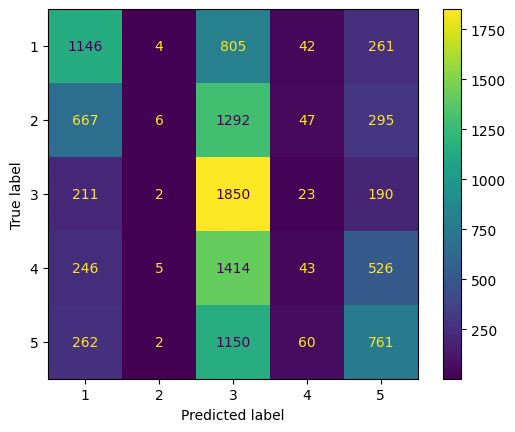

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(t_test_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

In [ ]:
#Training:
predicted_classes_train = []
for train_X in X_train_np:
  train_X_expand = np.expand_dims(train_X, axis=0)
  y_pred = model(train_X_expand, training=False)
  predicted_classes_train.append(np.argmax(y_pred[0])+1)

print(predicted_classes_train)

[3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 5, 1, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 5, 5, 3, 3, 3, 1, 3, 3, 5, 5, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 5, 1, 5, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 5, 3, 1, 3, 5, 3, 3, 1, 3, 3, 1, 5, 3, 5, 5, 3, 3, 3, 3, 3, 1, 3, 1, 3, 5, 3, 5, 3, 1, 3, 1, 3, 1, 5, 3, 1, 3, 3, 3, 3, 5, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 3, 3, 3, 3, 5, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 5, 1, 3, 5, 5, 3, 5, 5, 3, 5, 5, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 5, 1, 3, 3, 4, 5, 1, 5, 3, 3, 1, 1, 3, 3, 3, 3, 4, 1, 3, 5, 3, 4, 1, 3, 3, 5, 5, 5, 3, 3, 1, 3, 3, 3, 3, 5, 5, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 3, 5, 5, 1, 5, 5, 3, 1, 3, 1, 3, 1, 3, 3, 5, 3, 3, 5, 3, 1, 1, 5, 3, 3, 5, 3, 1, 3, 5, 1, 3, 3, 3, 5, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 5, 1, 1, 3, 3, 1, 1, 3, 3, 1, 5, 5, 3, 1, 5, 1, 3, 5, 3, 1, 5, 3, 3, 3, 3, 1, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 

In [ ]:
t_train_classes = []
for t in t_train_np:
  t_train_classes.append(np.argmax(t) + 1)
print(t_train_classes)

[5, 3, 5, 3, 4, 2, 2, 2, 2, 5, 5, 1, 5, 5, 1, 1, 1, 4, 1, 5, 4, 2, 5, 1, 5, 4, 1, 3, 5, 2, 2, 4, 5, 5, 2, 3, 4, 5, 4, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 4, 3, 1, 1, 1, 4, 4, 3, 5, 3, 4, 4, 1, 3, 2, 5, 3, 2, 3, 3, 5, 4, 3, 2, 2, 3, 1, 4, 3, 5, 2, 2, 4, 4, 2, 1, 4, 2, 1, 4, 4, 2, 5, 2, 1, 5, 2, 4, 1, 5, 4, 3, 3, 5, 5, 1, 5, 3, 2, 5, 4, 3, 5, 3, 5, 5, 2, 2, 5, 3, 4, 4, 5, 2, 4, 5, 2, 3, 4, 2, 4, 2, 2, 4, 5, 4, 5, 3, 2, 1, 4, 5, 1, 3, 1, 3, 1, 2, 3, 4, 5, 1, 1, 4, 4, 5, 4, 3, 1, 5, 1, 5, 5, 5, 2, 3, 1, 5, 4, 2, 1, 2, 2, 5, 4, 3, 3, 5, 2, 2, 2, 3, 3, 2, 3, 3, 4, 1, 2, 5, 2, 3, 3, 5, 5, 2, 5, 4, 5, 5, 4, 5, 5, 2, 4, 2, 5, 1, 4, 5, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 5, 1, 5, 4, 1, 5, 1, 4, 1, 2, 3, 3, 1, 5, 2, 3, 2, 1, 5, 5, 1, 2, 4, 2, 5, 3, 3, 4, 5, 4, 4, 4, 2, 2, 2, 3, 4, 2, 5, 1, 2, 2, 5, 5, 1, 4, 1, 3, 4, 2, 4, 1, 2, 5, 2, 5, 2, 2, 1, 3, 4, 1, 3, 5, 4, 1, 1, 3, 1, 1, 1, 1, 5, 4, 1, 5, 2, 3, 3, 3, 1, 3, 5, 3, 3, 3, 4, 2, 3, 4, 1, 4, 5, 3, 1, 3, 5, 5, 5, 3, 2, 1, 3, 3, 3, 2, 5, 4, 3, 3, 3, 5, 

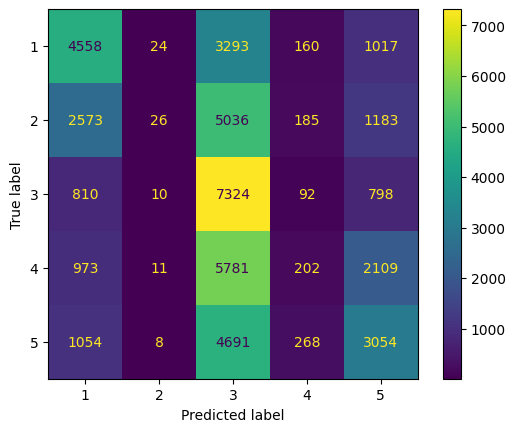

In [ ]:
cm = confusion_matrix(t_train_classes, predicted_classes_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
print(classification_report(t_train_classes, predicted_classes_train, target_names=target_names))

              precision    recall  f1-score   support

           1       0.46      0.50      0.48      9052
           2       0.33      0.00      0.01      9003
           3       0.28      0.81      0.42      9034
           4       0.22      0.02      0.04      9076
           5       0.37      0.34      0.35      9075

    accuracy                           0.34     45240
   macro avg       0.33      0.34      0.26     45240
weighted avg       0.33      0.34      0.26     45240



In [ ]:
print(classification_report(t_test_classes, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

           1       0.45      0.51      0.48      2258
           2       0.32      0.00      0.01      2307
           3       0.28      0.81      0.42      2276
           4       0.20      0.02      0.04      2234
           5       0.37      0.34      0.36      2235

    accuracy                           0.34     11310
   macro avg       0.33      0.34      0.26     11310
weighted avg       0.33      0.34      0.26     11310

